In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
categories = pd.read_excel("/content/drive/MyDrive/stock_categories.xlsx")
returns = pd.read_excel("/content/drive/MyDrive/daily_returns.xlsx",index_col=0)

print(categories.head())
print(returns.head())



            Category     Symbol         Company Name
0  Banking & Finance   HDFCBANK            HDFC Bank
1  Banking & Finance  ICICIBANK           ICICI Bank
2  Banking & Finance       SBIN  State Bank of India
3   Information Tech        TCS                  TCS
4   Information Tech       INFY              Infosys
            HDFCBANK  ICICIBANK    SBIN     TCS    INFY  HCLTECH  BAJAJ-AUTO  \
Date                                                                           
2023-02-02   -1.4869     1.1734  0.1422  1.5271  2.1049   1.5458     -0.5405   
2023-02-03    3.4584     0.6877  3.0487  0.6329  0.9882  -0.3001      1.6316   
2023-02-06   -0.4250    -1.1692  0.2205 -0.6418 -1.8476  -0.0392     -0.0896   
2023-02-07    0.1483    -0.1113  0.3117  0.3642 -0.4746  -1.5231      0.7885   
2023-02-08   -0.0121     0.7446  0.4844  1.3693  1.7985   1.4846      0.0219   

               M&M  MARUTI  HINDUNILVR  ...  HINDALCO      LT  ULTRACEMCO  \
Date                                    ... 

In [ ]:
#we pick least-correlated stock per sector
#algo: Computing correlation matrix within the sector. For each stock, calculate the average correlation with others and pick the stock that has the least average correlation.
selected_stocks = []

for sector in categories['Category'].unique():
    sector_stocks = categories[categories['Category']==sector]['Symbol'].tolist()

    if len(sector_stocks) < 2:
        selected_stocks.extend(sector_stocks)
        continue

    sector_returns = returns[sector_stocks]
    corr = sector_returns.corr()
    avg_corr = corr.mean()
    least_corr_stock = avg_corr.idxmin()
    selected_stocks.append(least_corr_stock)

#if we dont get 10 stocks from above,we will greedily add stocks to minimize average pairwise absolute correlation
#algo: iteratively add asset that minimizes the average pairwise absolute correlation within the selected set (compute the correlation matrix for the selected set, and calculate the average absolute correlation. Select the asset which gives least average absolute correlation).
while len(selected_stocks)<10:
    remaining = list(set(returns.columns)-set(selected_stocks))
    avg_pairwise_corr = {}
    for stock in remaining:
        temporary_set = selected_stocks + [stock]
        corr_matrix = returns[temporary_set].corr().abs()

        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        avg_pairwise_corr[stock] = upper_triangle.stack().mean()

    # select stock that minimizes average pairwise correlation
    best_stock = min(avg_pairwise_corr, key=avg_pairwise_corr.get)
    selected_stocks.append(best_stock)

selected_stocks=selected_stocks[:10]
selected_stocks


['SBIN',
 'HCLTECH',
 'BAJAJ-AUTO',
 'ITC',
 'RELIANCE',
 'SUNPHARMA',
 'HINDALCO',
 'ULTRACEMCO',
 'BHARTIARTL',
 'TRENT']

In [ ]:
R = returns[selected_stocks]

mu_daily = R.mean()
cov_daily = R.cov()

#Annualize
mu = mu_daily*252
cov = cov_daily*252

rf=0.065


In [ ]:
def portfolio_performance(w, mu, cov):
    pf_ret = np.dot(w, mu)
    pf_vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    return pf_ret, pf_vol

def sharpe_ratio(w, mu, cov, rf):
    pf_ret, pf_vol = portfolio_performance(w, mu, cov)
    return (pf_ret-rf)/pf_vol


In [ ]:
n = len(selected_stocks)

constraints = ({'type':'eq', 'fun':lambda w:np.sum(w)-1})
bounds = tuple((0,1) for _ in range(n))

ini_w=np.ones(n) / n


The Global Minimum Volatility (GMV) portfolio is a portfolio that has the lowest possible risk (volatility) for a given set of assets, without considering expected returns. Its primary goal is to minimize the portfolio's standard deviation.

In [ ]:
gmv=minimize(
    lambda w:portfolio_performance(w, mu, cov)[1],
    ini_w,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

w_gmv = gmv.x


## Sharpe Ratio Theory

The **Sharpe Ratio** is a measure to assess the performance of an investment by adjusting for its risk. It is defined as the average return earned in excess of the risk-free rate per unit of volatility or total risk.

### Formula:

$Sharpe Ratio = \frac{R_p - R_f}{\sigma_p}$

Where:
- $R_p$ = Expected portfolio return
- $R_f$ = Risk-free rate (e.g., the return on a U.S. Treasury bond)
- $\sigma_p$ = Portfolio standard deviation (volatility)

In [ ]:
max_sharpe = minimize(
    lambda w: -sharpe_ratio(w, mu, cov, rf),
    ini_w,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

w_max_sharpe = max_sharpe.x


In [ ]:
n_portfolios=10000

rets = []
vols = []
sharpes = []

for _ in range(n_portfolios):
    w = np.random.random(n)
    w /= np.sum(w)

    ret, vol = portfolio_performance(w, mu, cov)
    rets.append(ret)
    vols.append(vol)
    sharpes.append((ret-rf)/vol)

rets = np.array(rets)
vols = np.array(vols)
sharpes = np.array(sharpes)


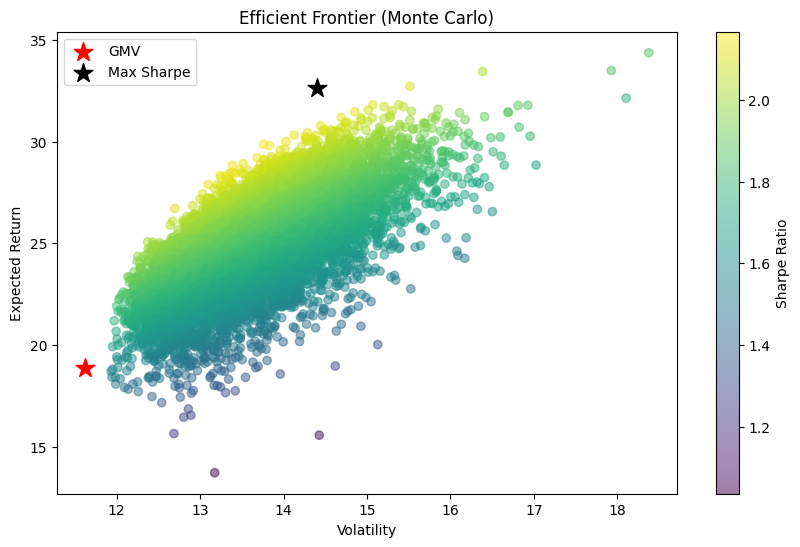

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(vols, rets, c=sharpes, cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')

gmv_ret, gmv_vol=portfolio_performance(w_gmv, mu, cov)
max_sharpe_ret, max_sharpe_vol=portfolio_performance(w_max_sharpe, mu, cov)

plt.scatter(gmv_vol, gmv_ret, c='red', marker='*', s=200, label='GMV')
plt.scatter(max_sharpe_vol, max_sharpe_ret, c='black', marker='*', s=200, label='Max Sharpe')

plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (Monte Carlo)')
plt.legend()
plt.show()


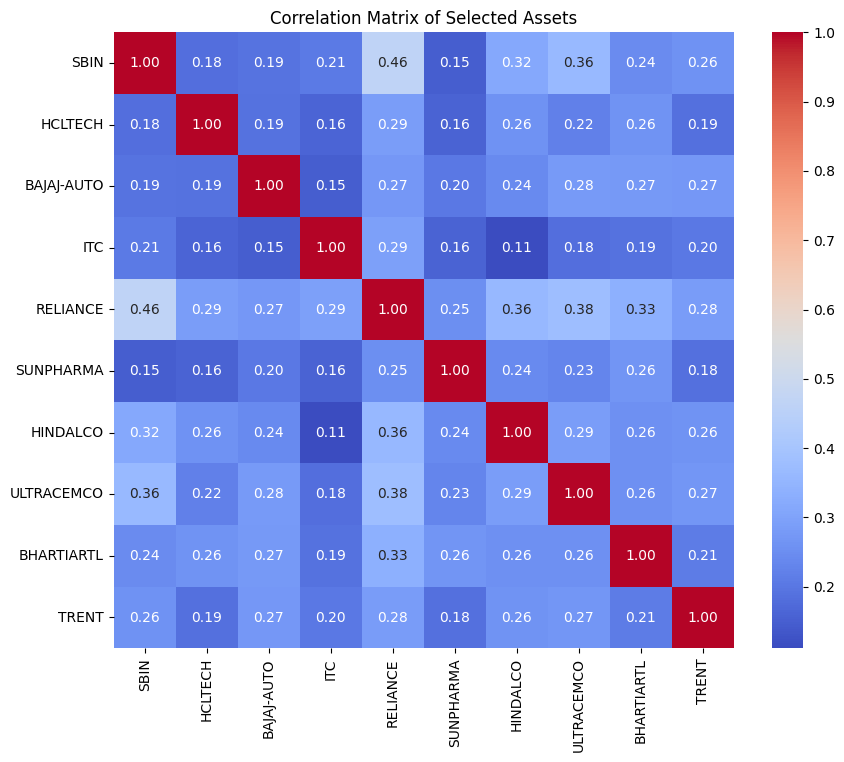

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(R.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Assets')
plt.show()


In [ ]:
weights=pd.DataFrame({
    'Stock':selected_stocks,
    'GMV Weight':w_gmv,
    'Max Sharpe Weight':w_max_sharpe
})

weights


,Stock,GMV Weight,Max Sharpe Weight
0,SBIN,8.402691e-02,1.581700e-01
1,HCLTECH,1.114988e-01,4.250083e-02
2,BAJAJ-AUTO,6.965165e-02,2.092403e-01
3,ITC,2.545351e-01,1.316900e-16
4,RELIANCE,2.554318e-02,1.248355e-16
5,SUNPHARMA,2.287081e-01,9.125012e-02
6,HINDALCO,4.743425e-03,2.280204e-02
7,ULTRACEMCO,1.036798e-01,2.920429e-02
8,BHARTIARTL,1.176130e-01,3.451900e-01
9,TRENT,2.233008e-16,1.016425e-01


In [ ]:
#Max Sharpe portfolio performance
final_return, final_volatility = portfolio_performance(w_max_sharpe, mu, cov)
final_sharpe = (final_return - rf) / final_volatility
print("Max Sharpe portfolio performance")
print(f"Expected Annual Return : {final_return:.2%}")
print(f"Annual Volatility      : {final_volatility:.2%}")
print(f"Final Sharpe Ratio     : {final_sharpe:.3f}")

#GMV portfolio performance
final_return, final_volatility = portfolio_performance(w_gmv, mu, cov)
final_sharpe = (final_return - rf) / final_volatility
print("GMV portfolio performance")
print(f"Expected Annual Return : {final_return:.2%}")
print(f"Annual Volatility      : {final_volatility:.2%}")
print(f"Final Sharpe Ratio     : {final_sharpe:.3f}")


Max Sharpe portfolio performance
Expected Annual Return : 3263.08%
Annual Volatility      : 1440.16%
Final Sharpe Ratio     : 2.261
GMV portfolio performance
Expected Annual Return : 1888.86%
Annual Volatility      : 1162.15%
Final Sharpe Ratio     : 1.620
